# Audit Data

This notebook goes though each of the steps in <b>Chapter 5.1 Setup Overview</b> for the Audit Data data set.

The main areas this notebook covers are:

- Building 5 machine learning models with the data set.
- View their performances with evaluation metrics.
- Apply feature importance for each model.
- Explore the top 3 most important features to see how a model reacts to changes to the given features.
- Build a visualisation tool to view and interact with each model's predictions.

<b>Student Name: </b> William King 

<b>Student Number: </b> 950178

<b>Last Updated: </b> July 7th 2020

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from kmeans_predict import predict # Seperate python file that has functions to help with predictions for KMeans.
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance 
from eli5.permutation_importance import get_score_importances
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import altair as alt
from altair import datum

Using TensorFlow backend.
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\willi\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import the Data Set

This involves preparing the data for training. 

The train / test split will be applied for the supervised models.

Some attributes are removed for training because they aren't essential to the prediction process:

- LOCATION_ID
- TOTAL
- Risk (Labels)

A unique ID is set for each data instance so that the model's predictions can be allocated to their respective data instance. This helps with the supervised algorithms to be displayed with the unsupervised algorithms in the visualisation tool due to the train / test split.

In [2]:
audit_df = pd.read_csv('Datasets/audit_data/audit_risk.csv')
anomaly_points_df = audit_df['Risk']
anomaly_points = anomaly_points_df.values.reshape(-1, 1)

# Shows No. points that are normal and fraudulent.
# 0 = normal, 1 = Fraud.
print(audit_df.pivot_table(index = ['Risk'], aggfunc = 'size')) 

# Check No. of NaN values for each attribute.
print(audit_df.isna().sum()) 

# Fill NaN values with 0.
audit_df.fillna(0, inplace = True)

# Add unique IDs for each data record. For visualisation purposes and in aid for test data.
audit_df['Unique_ID'] = None
for i in range(audit_df.shape[0]):
    audit_df['Unique_ID'][i] = "ID" + str(i)
#print(audit_df.head)

# Set index to Unique_ID.
audit_df = audit_df.set_index('Unique_ID')
#print(audit_df.loc['ID9'])

# Select the columns to be used for prediction.
irrelavent_columns = ['LOCATION_ID', 'TOTAL', 'Risk']
feature_columns = [i for i in audit_df.columns if (i not in irrelavent_columns)]
data_df = audit_df[feature_columns] # For unsupervised algorithms.
data_df = data_df.copy().reset_index() # Allows the Unique_ID column to be deleted (for training).
#print(data_df.columns)
#print(data_df.head)
#print(data_df.shape)

# Apply train / test split on the data. Used for supervised algorithms. Currently at 80 / 20 split.
train_data, test_data, train_labels, test_labels = train_test_split(data_df, anomaly_points_df, 
                                                                    test_size = 0.2, random_state = 1)

# Create copy for supervised algorithms (visualisation tool purposes)
# then remove Unique_ID for training.
test_data_with_ID = test_data.copy().reset_index()
del data_df['Unique_ID']
del train_data['Unique_ID']
del test_data['Unique_ID']

#print(audit_df.columns)
#print(test_data.shape)

Risk
0    471
1    305
dtype: int64
Sector_score      0
LOCATION_ID       0
PARA_A            0
Score_A           0
Risk_A            0
PARA_B            0
Score_B           0
Risk_B            0
TOTAL             0
numbers           0
Score_B.1         0
Risk_C            0
Money_Value       1
Score_MV          0
Risk_D            0
District_Loss     0
PROB              0
RiSk_E            0
History           0
Prob              0
Risk_F            0
Score             0
Inherent_Risk     0
CONTROL_RISK      0
Detection_Risk    0
Audit_Risk        0
Risk              0
dtype: int64


## Adjust Data Set before training

The data is normalised before training.

In [3]:
#Normalise the data in dataframe (Unsupervised).
standardised_data = StandardScaler().fit_transform(data_df)

# Normalise the data based on the training data (Supervised).
normaliser = StandardScaler().fit(train_data)
train_data = normaliser.transform(train_data)
test_data = normaliser.transform(test_data)

#Seperate the normalised data from the labels (Unsupervised).
x = standardised_data
y = anomaly_points

# PCA Reducted Data (for axis option in visualisation tool).
pca_supervised = PCA(n_components = 2).fit_transform(test_data)
pca_unsupervised = PCA(n_components = 2).fit_transform(x)

## Train Unsupervised Algorithms

- K-Means Clustering
- K-Nearest Neighbours
- Autoencoder

In [4]:
#----------K-Means Clustering----------
kmeans_threshold = 0.4
kmeans_model = KMeans(2) # 2, 3, 4 is optimum (with normalised data).
kmeans_model.fit(x)
kmeans_pred = predict(kmeans_model, x, contamination = kmeans_threshold)


#----------K-Nearest Neighbours----------
knn_threshold = 0.42
knn_model = KNN(n_neighbors = 4, contamination = knn_threshold) # 4 is optimum (with normalised data).
knn_model.fit(x)
knn_pred = knn_model.predict(x)


#----------AutoEncoder----------
ae_threshold = 0.37
ae_model = AutoEncoder(hidden_neurons = [24, 12, 6, 2, 6, 12, 24],
                                epochs = 100,
                                verbose = 0,
                                contamination = ae_threshold)
ae_model.fit(x)
ae_pred = ae_model.labels_

## Train Supervised Algorithms

- Random Forest
- Neural Network (MLP)

In [5]:
#----------Random Forest----------
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(train_data, train_labels)
rf_pred = rf_model.predict(test_data)


#----------Neural Network (MLP)----------
nn_model = MLPClassifier(hidden_layer_sizes=(100, ), max_iter = 1000).fit(train_data, train_labels)
nn_pred= nn_model.predict(test_data)

## Evaluation Metrics

The positive class is fraudulent because this is what we're looking for.

The following metrics used are:

- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix

In [6]:
print("----------Unsupervised Algorithms----------")
print("K-Means Clustering Performance in %:")
print("Accuracy:", accuracy_score(y, kmeans_pred) * 100)
print("Precision:", precision_score(y, kmeans_pred) * 100)
print("Recall:", recall_score(y, kmeans_pred) * 100)
print("F1 Score:", f1_score(y, kmeans_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(y, kmeans_pred))
print()
print("K-Nearest Neighbours Performance in %:")
print("Accuracy:", accuracy_score(y, knn_pred) * 100)
print("Precision:", precision_score(y, knn_pred) * 100)
print("Recall:", recall_score(y, knn_pred) * 100)
print("F1 Score:", f1_score(y, knn_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(y, knn_pred))
print()
print("AutoEncoder Performance in %:")
print("Accuracy:", accuracy_score(y, ae_pred) * 100)
print("Precision:", precision_score(y, ae_pred) * 100)
print("Recall:", recall_score(y, ae_pred) * 100)
print("F1 Score:", f1_score(y, ae_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(y, ae_pred))
print()

#Supervised Techniques
print("----------Supervised Algorithms----------")
print("Random Forest Performance in %:")
print("Accuracy:", accuracy_score(test_labels, rf_pred) * 100)
print("Precision:", precision_score(test_labels, rf_pred) * 100)
print("Recall:", recall_score(test_labels, rf_pred) * 100)
print("F1 Score:", f1_score(test_labels, rf_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(test_labels, rf_pred))
print()
print("Neural Network Performance in %:")
print("Accuracy:", accuracy_score(test_labels, nn_pred) * 100)
print("Precision:", precision_score(test_labels, nn_pred) * 100)
print("Recall:", recall_score(test_labels, nn_pred) * 100)
print("F1 Score:", f1_score(test_labels, nn_pred) * 100)
print("Confusion Matrix: ")
print(confusion_matrix(test_labels, nn_pred))

----------Unsupervised Algorithms----------
K-Means Clustering Performance in %:
Accuracy: 95.4896907216495
Precision: 93.54838709677419
Recall: 95.08196721311475
F1 Score: 94.3089430894309
Confusion Matrix: 
[[451  20]
 [ 15 290]]

K-Nearest Neighbours Performance in %:
Accuracy: 93.55670103092784
Precision: 90.9967845659164
Recall: 92.78688524590164
F1 Score: 91.88311688311688
Confusion Matrix: 
[[443  28]
 [ 22 283]]

AutoEncoder Performance in %:
Accuracy: 91.23711340206185
Precision: 91.28919860627178
Recall: 85.90163934426229
F1 Score: 88.51351351351352
Confusion Matrix: 
[[446  25]
 [ 43 262]]

----------Supervised Algorithms----------
Random Forest Performance in %:
Accuracy: 100.0
Precision: 100.0
Recall: 100.0
F1 Score: 100.0
Confusion Matrix: 
[[99  0]
 [ 0 57]]

Neural Network Performance in %:
Accuracy: 98.71794871794873
Precision: 100.0
Recall: 96.49122807017544
F1 Score: 98.21428571428572
Confusion Matrix: 
[[99  0]
 [ 2 55]]


## Permutation Importance 

Feature importance is explored for each model.

It shows the features that impacted the prediction stage the most by calculating the model's mean decrease in performance when a feature is not present.

In this case, the feature is replaced by random noise so that it will no longer hold any useful information.

### kMeans

In [7]:
# Score function to determine performance (accuracy is used).
def kmeans_score(X, y):
    y_pred = predict(kmeans_model, X, contamination = kmeans_threshold)
    return accuracy_score(y, y_pred)

# Calculate mean accuracy decrease.
base_score, score_decreases = get_score_importances(kmeans_score, x, y)
feature_importances = np.mean(score_decreases, axis = 0)

# Label each score to their respective features, then sort them in descending order.
feature_importance_dict = {}
for i, feature_name in enumerate(data_df.columns):
    feature_importance_dict[feature_name] = feature_importances[i]
perm_df = pd.DataFrame(sorted(feature_importance_dict.items(), key = lambda x: x[1], reverse = True))
perm_df.columns = ['Feature', 'Weight']
print(perm_df)

           Feature    Weight
0    District_Loss  0.081443
1         Score_MV  0.078866
2        Score_B.1  0.055670
3             Prob  0.051031
4            Score  0.050000
5           Risk_C  0.045361
6           RiSk_E  0.043814
7          numbers  0.034536
8     CONTROL_RISK  0.030928
9           PARA_A  0.030412
10         Score_B  0.029639
11          Risk_A  0.028351
12         History  0.024227
13            PROB  0.024227
14     Money_Value  0.021134
15          Risk_F  0.019072
16   Inherent_Risk  0.019072
17          Risk_D  0.017010
18         Score_A  0.016495
19          PARA_B  0.011856
20          Risk_B  0.011340
21      Audit_Risk  0.007732
22  Detection_Risk  0.000000
23    Sector_score -0.001031


### kNearest Neighbours 

In [8]:
# Score function to determine performance (accuracy is used).
def knn_score(X, y):
    y_pred = knn_model.predict(X)
    return accuracy_score(y, y_pred)

# Calculate mean accuracy decrease.
base_score, score_decreases = get_score_importances(knn_score, x, y)
feature_importances = np.mean(score_decreases, axis = 0)

# Label each score to their respective features, then sort them in descending order.
feature_importance_dict = {}
for i, feature_name in enumerate(data_df.columns):
    feature_importance_dict[feature_name] = feature_importances[i]
perm_df = pd.DataFrame(sorted(feature_importance_dict.items(), key = lambda x: x[1], reverse = True))
perm_df.columns = ['Feature', 'Weight']
print(perm_df)

           Feature    Weight
0            Score  0.384536
1          Score_A  0.297165
2           Risk_A  0.282732
3           PARA_A  0.257732
4          Score_B  0.206443
5    Inherent_Risk  0.158247
6         Score_MV  0.140206
7     CONTROL_RISK  0.122938
8      Money_Value  0.122680
9           PARA_B  0.122680
10      Audit_Risk  0.118557
11          Risk_B  0.115979
12          Risk_D  0.107216
13          RiSk_E  0.096134
14   District_Loss  0.089691
15       Score_B.1  0.048711
16          Risk_C  0.048196
17         numbers  0.047423
18    Sector_score  0.041495
19          Risk_F  0.035567
20         History  0.034278
21            Prob  0.033247
22            PROB  0.014433
23  Detection_Risk  0.000000


### Autoencoder 

In [9]:
# Score function to determine performance (accuracy is used).
def ae_score(X, y):
    y_pred = ae_model.predict(X)
    return accuracy_score(y, y_pred)

# Calculate mean accuracy decrease.
base_score, score_decreases = get_score_importances(ae_score, x, y)
feature_importances = np.mean(score_decreases, axis = 0)

# Label each score to their respective features, then sort them in descending order.
feature_importance_dict = {}
for i, feature_name in enumerate(data_df.columns):
    feature_importance_dict[feature_name] = feature_importances[i]
perm_df = pd.DataFrame(sorted(feature_importance_dict.items(), key = lambda x: x[1], reverse = True))
perm_df.columns = ['Feature', 'Weight']
print(perm_df)

           Feature    Weight
0          Score_B  0.108505
1         Score_MV  0.104124
2            Score  0.064175
3          Score_A  0.060052
4           RiSk_E  0.058763
5           Risk_C  0.047680
6    District_Loss  0.047423
7        Score_B.1  0.045361
8          numbers  0.039948
9             Prob  0.035052
10          Risk_A  0.034794
11         History  0.030670
12    CONTROL_RISK  0.030155
13          PARA_A  0.029897
14          PARA_B  0.021134
15          Risk_B  0.018814
16   Inherent_Risk  0.018557
17     Money_Value  0.017268
18            PROB  0.017268
19          Risk_F  0.016495
20          Risk_D  0.015979
21      Audit_Risk  0.010567
22  Detection_Risk  0.000000
23    Sector_score -0.020876


### Random Forest 

In [5]:
rf_perm = PermutationImportance(rf_model, random_state = 1).fit(test_data, test_labels)
eli5.show_weights(rf_perm, top = data_df.shape[1], feature_names = data_df.columns.tolist())

Weight,Feature
0.1808 ± 0.0096,Audit_Risk
0 ± 0.0000,Detection_Risk
0 ± 0.0000,PARA_A
0 ± 0.0000,Score_A
0 ± 0.0000,Risk_A
0 ± 0.0000,PARA_B
0 ± 0.0000,Score_B
0 ± 0.0000,Risk_B
0 ± 0.0000,numbers
0 ± 0.0000,Score_B.1


### Neural Network 

In [11]:
nn_perm = PermutationImportance(nn_model, random_state = 1).fit(test_data, test_labels)
eli5.show_weights(nn_perm, top = data_df.shape[1], feature_names = data_df.columns.tolist())

Weight,Feature
0.1269 ± 0.0375,Score_MV
0.0462 ± 0.0170,RiSk_E
0.0423 ± 0.0264,PARA_B
0.0372 ± 0.0205,Risk_B
0.0333 ± 0.0096,District_Loss
0.0179 ± 0.0126,Risk_A
0.0167 ± 0.0103,Inherent_Risk
0.0141 ± 0.0188,PARA_A
0.0128 ± 0.0081,Score_B
0.0115 ± 0.0051,CONTROL_RISK


## Partial Dependence Plots (PDP) 

This explores how a model responds to changes to a given feature and shows the direction it's influencing.

These will be applied to the top 3 most impactful features for each model.

### kMeans 

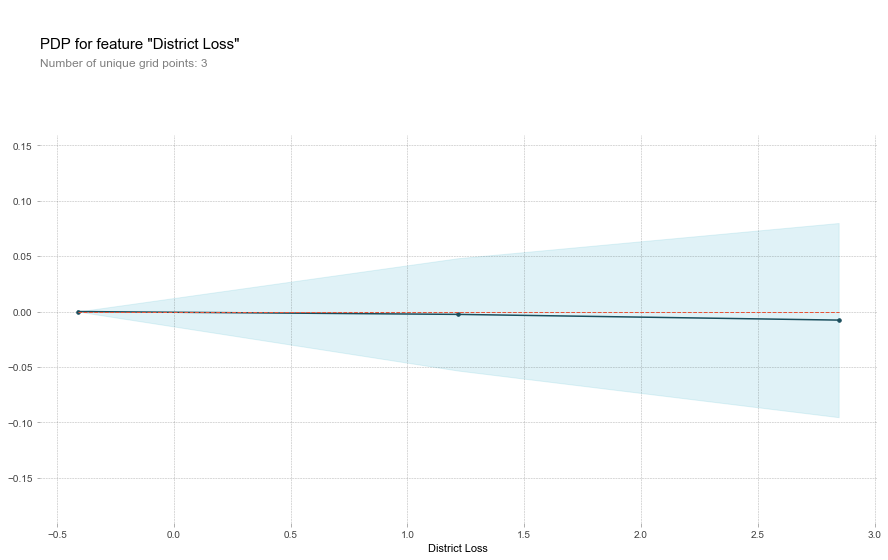

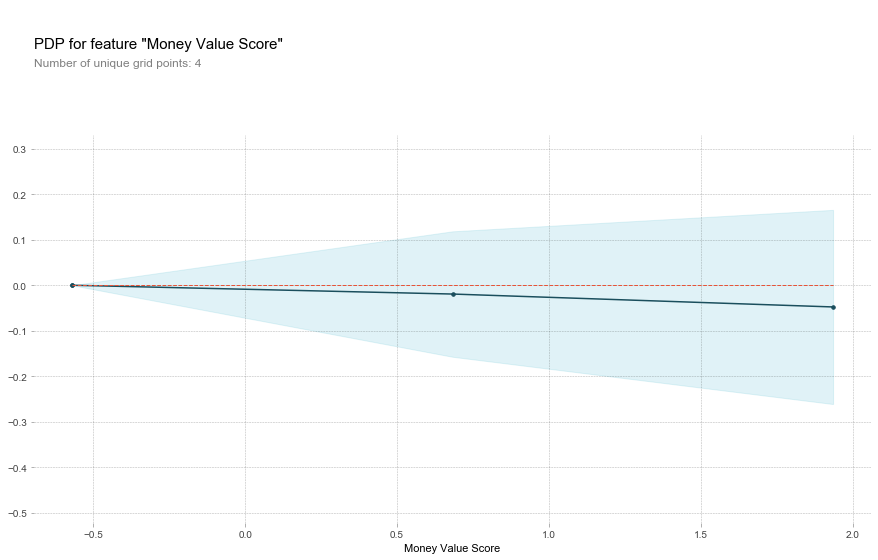

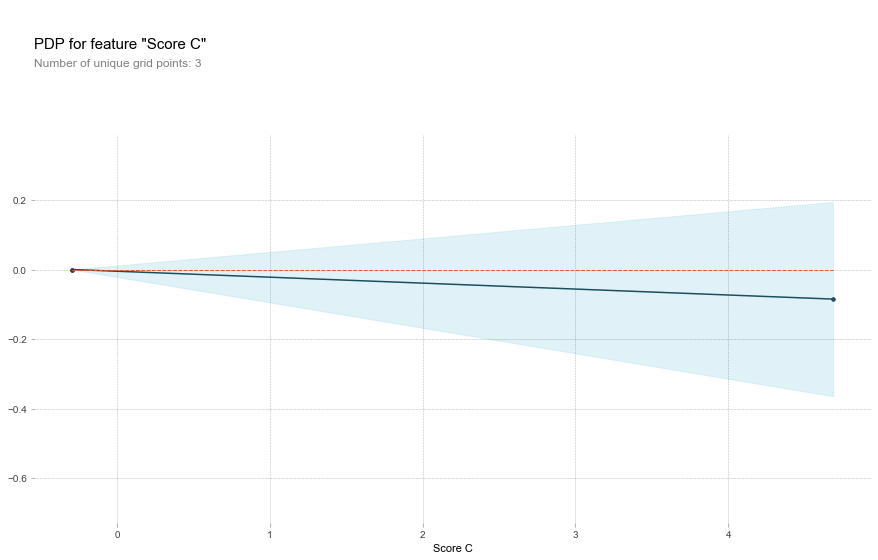

In [12]:
# Create a new dataframe that holds the normalised data, each model was trained using normalised data.
# It contains the features used for training.
df_columns = data_df.columns
new_df = pd.DataFrame(x)
new_df.columns = df_columns

# Create plots for the top 3 features.
pdp_district_loss = pdp.pdp_isolate(model = kmeans_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'District_Loss')

pdp_score_mv = pdp.pdp_isolate(model = kmeans_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Score_MV')

pdp_score_c = pdp.pdp_isolate(model = kmeans_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Score_B.1')

# plot them.
pdp.pdp_plot(pdp_district_loss, 'District Loss')
pdp.pdp_plot(pdp_score_mv, 'Money Value Score')
pdp.pdp_plot(pdp_score_c, 'Score C')
plt.show()

### kNearest Neighbours 

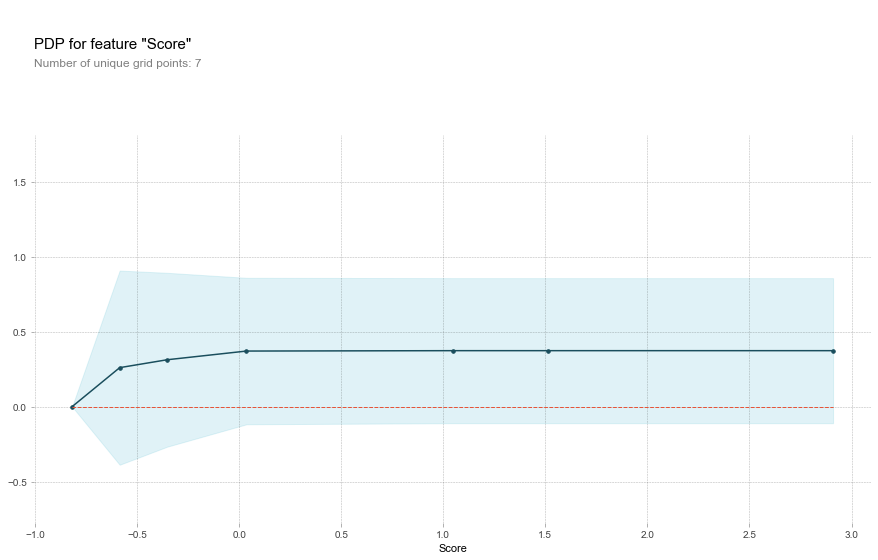

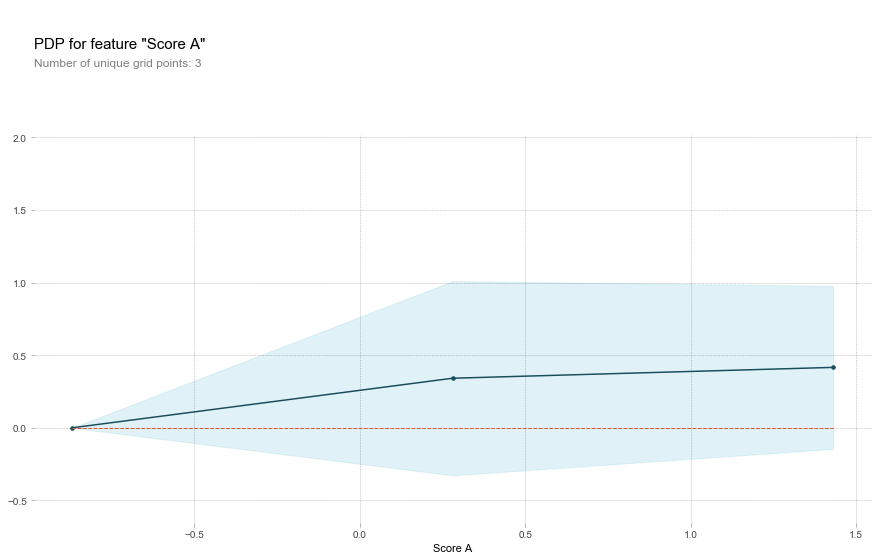

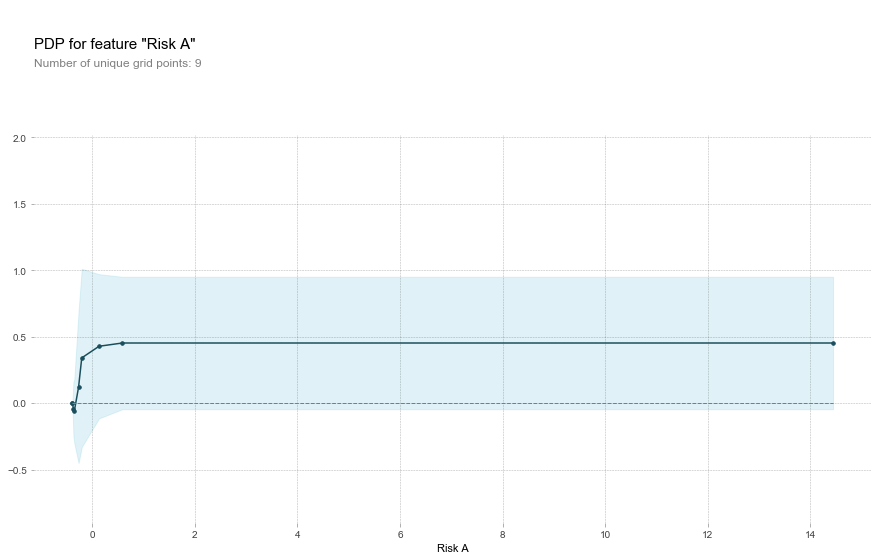

In [13]:
# Create plots for the top 3 features.
pdp_score = pdp.pdp_isolate(model = knn_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Score')

pdp_score_a = pdp.pdp_isolate(model = knn_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Score_A')

pdp_risk_a = pdp.pdp_isolate(model = knn_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Risk_A')

# plot them.
pdp.pdp_plot(pdp_score, 'Score')
pdp.pdp_plot(pdp_score_a, 'Score A')
pdp.pdp_plot(pdp_risk_a, 'Risk A')
plt.show()

### AutoEncoder

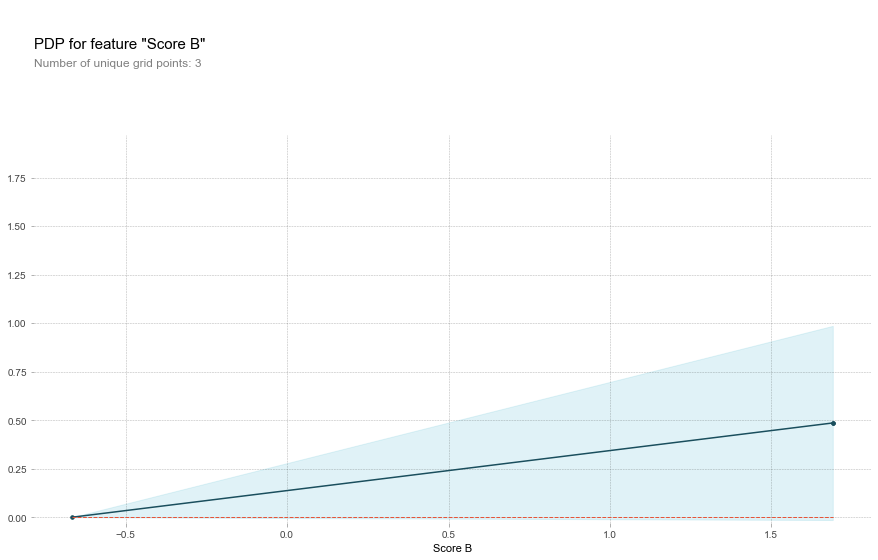

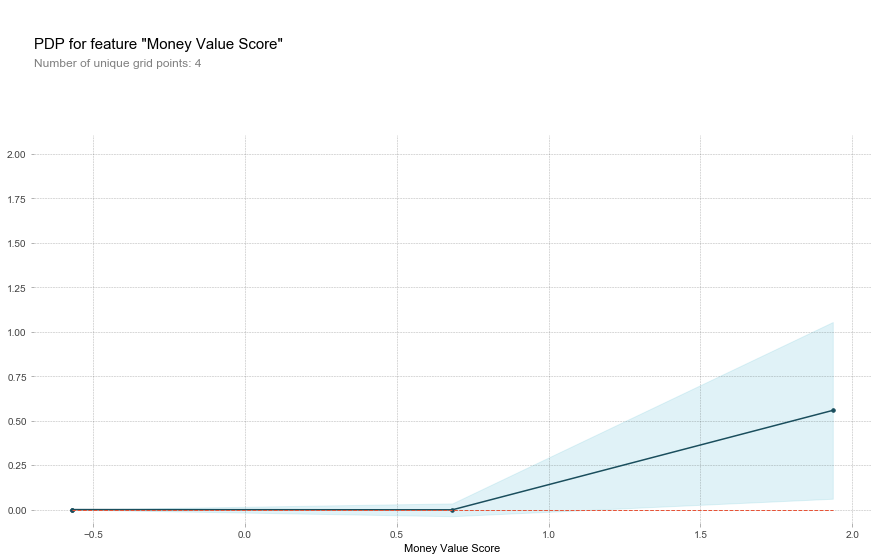

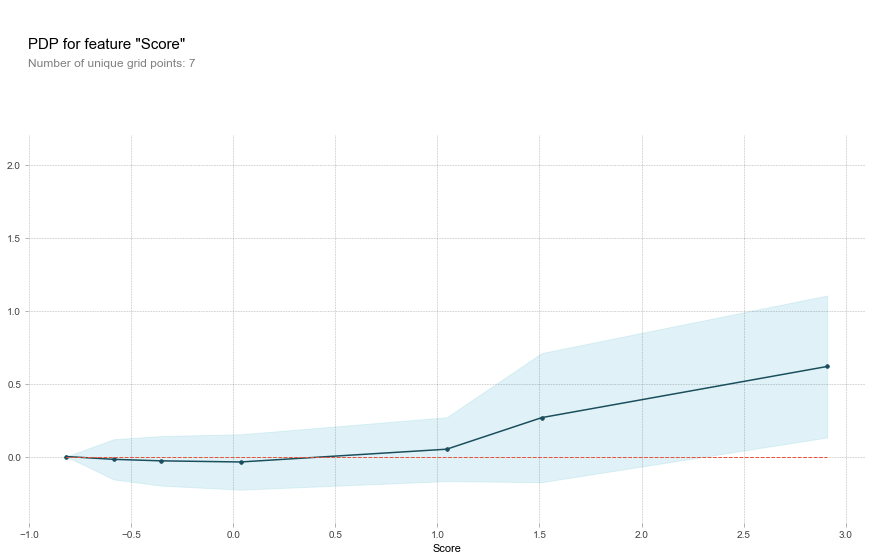

In [14]:
# Create plots for the top 3 features.
pdp_score_b = pdp.pdp_isolate(model = ae_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Score_B')

pdp_score_mv = pdp.pdp_isolate(model = ae_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Score_MV')

pdp_score = pdp.pdp_isolate(model = ae_model, dataset = new_df, model_features = data_df.columns, 
                                    feature = 'Score')

# plot them.
pdp.pdp_plot(pdp_score_b, 'Score B')
pdp.pdp_plot(pdp_score_mv, 'Money Value Score')
pdp.pdp_plot(pdp_score, 'Score')
plt.show()

### Random Forest

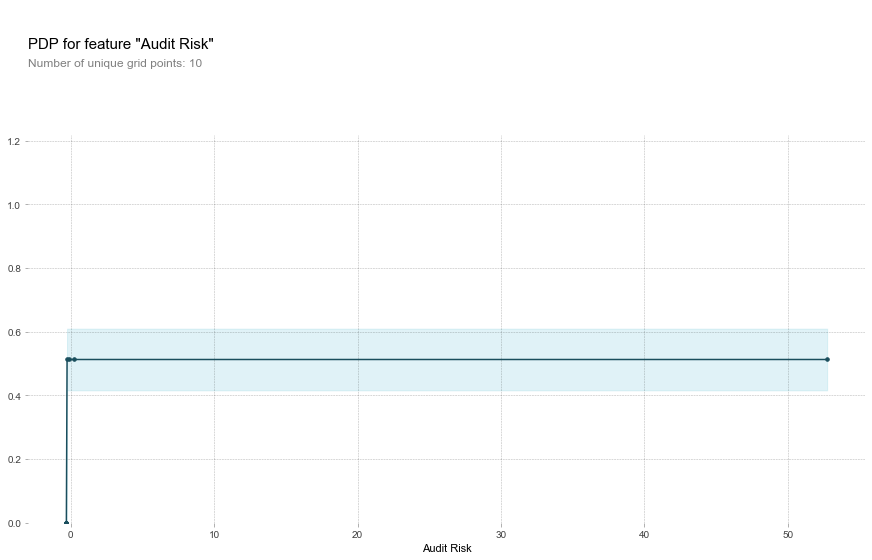

In [7]:
# Based on the testing data.
df_columns = data_df.columns
new_df_supervised = pd.DataFrame(test_data)
new_df_supervised.columns = df_columns

# Create plot for Audit Risk.
pdp_audit_risk = pdp.pdp_isolate(model = rf_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'Audit_Risk')

# plot it.
pdp.pdp_plot(pdp_audit_risk, 'Audit Risk')
plt.show()

### Neural Network (MLP)

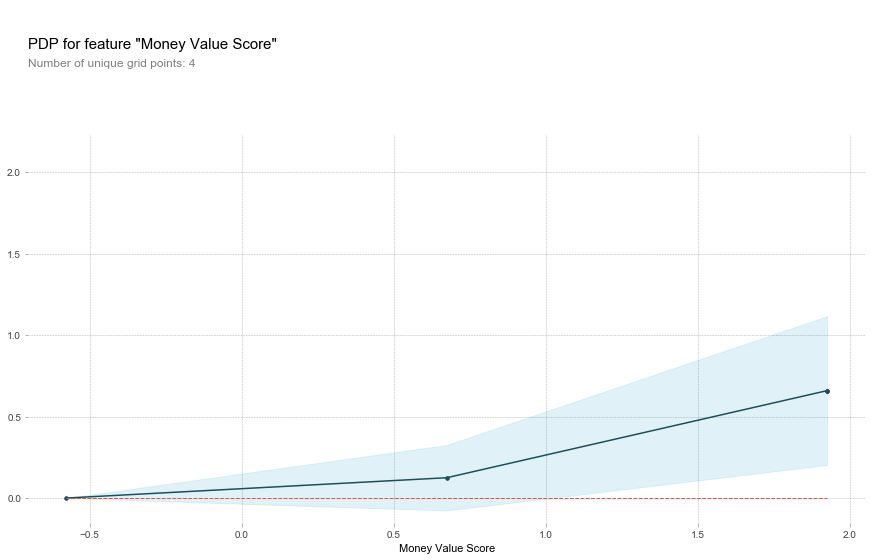

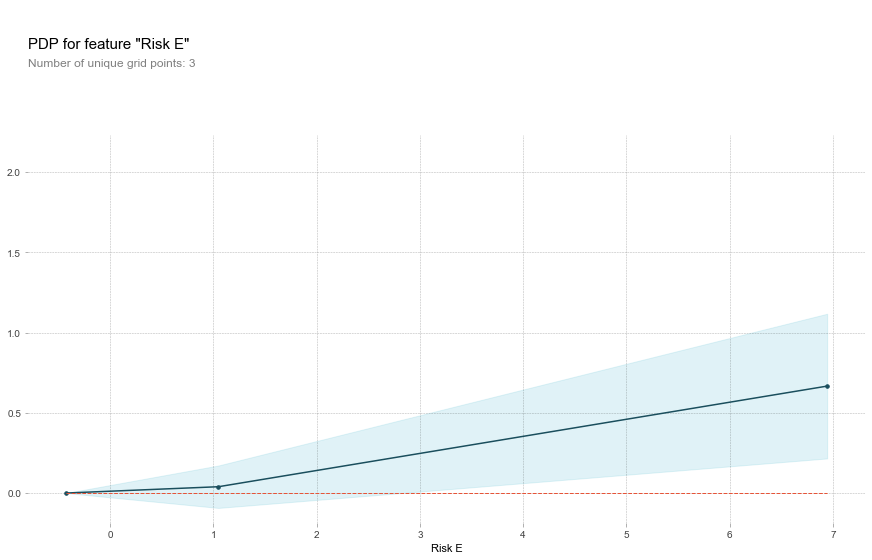

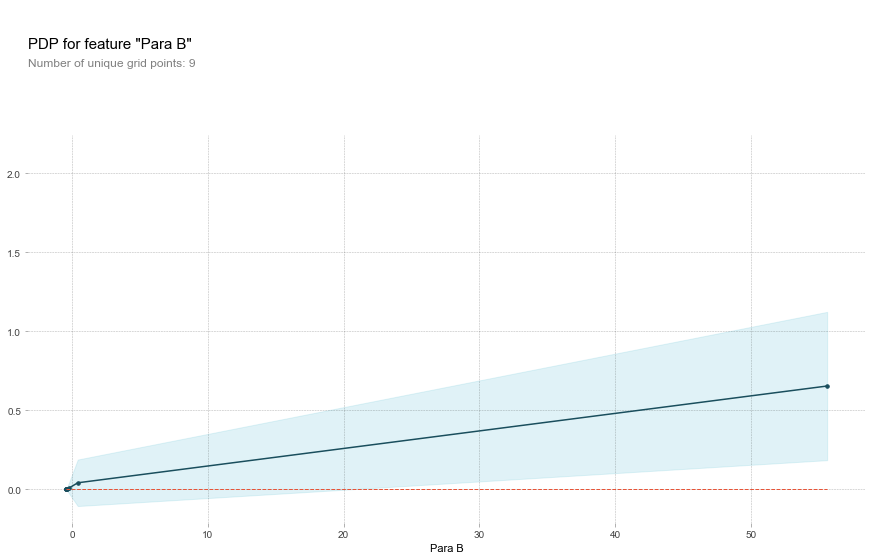

In [8]:
# Create plots for the top 3 features.
pdp_score_mv = pdp.pdp_isolate(model = nn_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'Score_MV')

pdp_risk_e = pdp.pdp_isolate(model = nn_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'RiSk_E')

pdp_para_b = pdp.pdp_isolate(model = nn_model, dataset = new_df_supervised, model_features = data_df.columns, 
                                    feature = 'PARA_B')


# plot them.
pdp.pdp_plot(pdp_score_mv, 'Money Value Score')
pdp.pdp_plot(pdp_risk_e, 'Risk E')
pdp.pdp_plot(pdp_para_b, 'Para B')
plt.show()

## Visualise the Results 

- A graph will be shown for each algorithm to display each model's results.
- The data shown can be filtered with the use of sliders / dropdown menus.
- The graphs are multi-coordinated for easy comparisons.
- Certain attributes will be shown for a data point when the mouse hovers over it. 
- Each data point will be labelled based on the <b>true</b> labels.

<b>Note:</b> The most recent predictions of each model will be shown.

### Prepare the data 

- Creates a data frame for the unsupervised and supervised models.
- The unique ID is used to fetch the corresponding data records for the testing split.
- So the unsupervised graphs will show the whole data set, while the supervised graphs will show the testing data.

In [6]:
# Create a seperate dataframe for supervised algorithms.
supervised_df = pd.DataFrame()

for i in range(test_data_with_ID.shape[0]):
    matching_ID = audit_df.loc[test_data_with_ID['Unique_ID'][i]]
    supervised_df = supervised_df.append(matching_ID)
#print(supervised_df.shape)

# Add model predictions to their respective dataframes.
audit_df['KMeans_Predict'] = kmeans_pred
audit_df['KNN_Predict'] = knn_pred
audit_df['AE_Predict'] = ae_pred
supervised_df['RF_Predict'] = rf_pred
supervised_df['NN_Predict'] = nn_pred

# Include PCA reducted versions of both dataframes.
audit_df['PCA_axis1'] = pca_unsupervised[:,0]
audit_df['PCA_axis2'] = pca_unsupervised[:,1]
#print(pca_unsupervised[:,0])
supervised_df['PCA_axis1'] = pca_supervised[:,0]
supervised_df['PCA_axis2'] = pca_supervised[:,1]
#print(pca_supervised[:,0])

# Remove columns that aren't used. (Reduces lag on visualisation)
relavent_audit_columns = ['Money_Value', 'Audit_Risk', 'Inherent_Risk', 'CONTROL_RISK', 'Detection_Risk', 
                    'Risk', 'KMeans_Predict', 'KNN_Predict', 'AE_Predict', 'PCA_axis1', 'PCA_axis2']
relavent_supervised_columns = ['Money_Value', 'Audit_Risk', 'Inherent_Risk', 'CONTROL_RISK', 'Detection_Risk', 
                    'Risk', 'RF_Predict', 'NN_Predict', 'PCA_axis1', 'PCA_axis2']
audit_columns = [i for i in audit_df.columns if (i in relavent_audit_columns)]
supervised_columns = [i for i in supervised_df.columns if (i in relavent_supervised_columns)]

audit_df = audit_df[audit_columns]
supervised_df = supervised_df[supervised_columns]

### Create the filters 

The data can be filtered by the following features:

- Money Value Score
- Audit Risk
- Risk (True Labels)
- <b> Dynamic axis have been included </b>
- <b> PCA axis option included </b>

Filter by <b>company sector</b> woud've been added (using sector score), but the number of companies in each sector was slightly inconsistent with the data set description.

In [7]:
# Elements for fraud dropdown filter.
fraud_dropdown = alt.binding_select(options = [0, 1], name = "Fraud: ")
fraud_select = alt.selection_single(fields = ['Risk'], bind = fraud_dropdown)

# Elements for the audit risk slider.
audit_risk_slider = alt.binding_range(min = audit_df['Audit_Risk'].min(), 
                                     max = audit_df['Audit_Risk'].max(), 
                                     step = 10, 
                                     name = 'Audit Risk:'
                                    )
select_audit_risk = alt.selection_single(fields = ['Audit_Risk'], 
                                        bind = audit_risk_slider,
                                        init = {'Audit_Risk': 0} 
                                       )

# Elements for the money value slider.
money_value_slider = alt.binding_range(min = audit_df['Money_Value'].min(), 
                                     max = audit_df['Money_Value'].max(), 
                                     step = 10, 
                                     name = 'Money Value:'
                                    )
select_money_value = alt.selection_single(fields = ['Money_Value'], 
                                        bind = money_value_slider,
                                        init = {'Money_Value': 0} 
                                       )

# For multi-coordinate zooming.
zoom = alt.selection_interval(bind = 'scales')


# Dropdown filters for selecting the axis' attributes.
columns = ['Money_Value', 'Audit_Risk', 'Inherent_Risk', 'CONTROL_RISK', 'Detection_Risk', 'PCA_axis1', 'PCA_axis2']
select_box_column = alt.binding_select(options = columns, name = 'Column: ')
sel_col = alt.selection_single(fields = ['column'], bind = select_box_column, init = {'column': 'Audit_Risk'})

rows = ['Money_Value', 'Audit_Risk', 'Inherent_Risk', 'CONTROL_RISK', 'Detection_Risk', 'PCA_axis1', 'PCA_axis2']
select_box_row = alt.binding_select(options = rows, name = 'Row: ')
sel_row = alt.selection_single(fields = ['row'], bind = select_box_row, init = {'row': 'Money_Value'})

### Create each graph then display them 

In [8]:
# Set Global variables that all graphs will use.
circle_size = 50
graph_height = 230
graph_width = 230
#x_axis = alt.X('Money_Value:Q', scale = alt.Scale(zero = False))
#y_axis = alt.Y('Audit_Risk:Q', scale = alt.Scale(zero = False))

#---------------Unsupervised Algorithms---------------
#----------KMeans Clustering Graph----------
kmeans_graph = alt.Chart(audit_df).transform_fold( # transform_fold and transform_filter are used
    columns,                                       # for the dynamic axis selection.
    as_= ['column', 'Column']
).transform_fold(
    rows,
    as_= ['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('KMeans_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Money_Value:Q', title = 'Money Value'),
               alt.Tooltip('Audit_Risk:Q', title = 'Audit Risk'),
               alt.Tooltip('Inherent_Risk:Q', title = 'Inherent Risk'),
               alt.Tooltip('CONTROL_RISK:Q', title = 'Control Risk'),
               alt.Tooltip('Detection_Risk:Q', title = 'Detection Risk'),
               alt.Tooltip('KMeans_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Risk:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'KMeans Clustering'
)

#----------K Nearest Neighbours Graph----------
knn_graph = alt.Chart(audit_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('KNN_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Money_Value:Q', title = 'Money Value'),
               alt.Tooltip('Audit_Risk:Q', title = 'Audit Risk'),
               alt.Tooltip('Inherent_Risk:Q', title = 'Inherent Risk'),
               alt.Tooltip('CONTROL_RISK:Q', title = 'Control Risk'),
               alt.Tooltip('Detection_Risk:Q', title = 'Detection Risk'),
               alt.Tooltip('KNN_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Risk:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'K-Nearest Neighbours'
)

#----------AutoEncoder Graph----------
ae_graph = alt.Chart(audit_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('AE_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Money_Value:Q', title = 'Money Value'),
                alt.Tooltip('Audit_Risk:Q', title = 'Audit Risk'),
                alt.Tooltip('Inherent_Risk:Q', title = 'Inherent Risk'),
                alt.Tooltip('CONTROL_RISK:Q', title = 'Control Risk'),
                alt.Tooltip('Detection_Risk:Q', title = 'Detection Risk'),
                alt.Tooltip('AE_Predict:Q', title = 'Prediction'),
                alt.Tooltip('Risk:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'AutoEncoder'
)

#---------------Supervised Algorithms---------------
#----------Random Forest Graph----------
rf_graph = alt.Chart(supervised_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('RF_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Money_Value:Q', title = 'Money Value'),
               alt.Tooltip('Audit_Risk:Q', title = 'Audit Risk'),
               alt.Tooltip('Inherent_Risk:Q', title = 'Inherent Risk'),
               alt.Tooltip('CONTROL_RISK:Q', title = 'Control Risk'),
               alt.Tooltip('Detection_Risk:Q', title = 'Detection Risk'),
               alt.Tooltip('RF_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Risk:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'Random Forest'
)

#----------Neural Network Graph----------
nn_graph = alt.Chart(supervised_df).transform_fold(
    columns,
    as_=['column', 'Column']
).transform_fold(
    rows,
    as_=['row', 'Row']
).transform_filter(
    sel_col  
).transform_filter(
    sel_row  
).mark_point(filled = True).encode(
    x = 'Row:Q', 
    y = 'Column:Q',
    color = alt.Color('NN_Predict:O', 
                      title = 'Fraud', 
                      scale = alt.Scale(domain = [0, 1], 
                                        range = ['white', 'red'])
                     ),
    stroke = alt.value('black'),
    strokeWidth = alt.value(0.5),
    size = alt.value(circle_size),
    opacity = alt.value(1),
    tooltip = [alt.Tooltip('Money_Value:Q', title = 'Money Value'),
               alt.Tooltip('Audit_Risk:Q', title = 'Audit Risk'),
               alt.Tooltip('Inherent_Risk:Q', title = 'Inherent Risk'),
               alt.Tooltip('CONTROL_RISK:Q', title = 'Control Risk'),
               alt.Tooltip('Detection_Risk:Q', title = 'Detection Risk'),
               alt.Tooltip('NN_Predict:Q', title = 'Prediction'),
               alt.Tooltip('Risk:Q', title = 'Actual')]
).properties(
    width = graph_width,
    height = graph_height,
    title = 'Neural Network (MLP)'
)


# Combine each graph and apply filters.
(kmeans_graph | knn_graph | ae_graph).add_selection(
    fraud_select
).transform_filter(
    fraud_select
).add_selection(select_audit_risk).transform_filter((select_audit_risk['Audit_Risk'] <= datum['Audit_Risk'])
).add_selection(select_money_value).transform_filter((select_money_value['Money_Value'] <= datum['Money_Value'])
).add_selection(
    zoom
).add_selection(
    sel_row
).add_selection(
    sel_col
) & (rf_graph | nn_graph).add_selection(
    fraud_select
).transform_filter(
    fraud_select
).add_selection(select_audit_risk).transform_filter((select_audit_risk['Audit_Risk'] <= datum['Audit_Risk'])
).add_selection(select_money_value).transform_filter((select_money_value['Money_Value'] <= datum['Money_Value'])
).add_selection(
    zoom
).add_selection(
    sel_row
).add_selection(
    sel_col
)

alt.VConcatChart(...)